In [15]:
#library installation 
def install_and_import(package):
    import importlib
    try:
        importlib.import_module(package)
    except ImportError:
        import pip
        pip.main(['install', package])
    finally:
        globals()[package] = importlib.import_module(package)


install_and_import('pyspark')
install_and_import('matplotlib')
install_and_import('seaborn')
install_and_import('numpy')
install_and_import('sklearn')
install_and_import('datetime')
install_and_import('pandas')
install_and_import('nltk')
install_and_import('os')
install_and_import('time')

In [16]:
from pyspark.sql import SparkSession
import datetime
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

In [17]:
data = spark.read.json("Musical_Instruments_5.json")
data.show(100,truncate=True)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|
|1384719342|  [1, 1]|    5.0|The primary job o...|08 28, 2013|A195EZSQDW3E21|Rick Bennette "Ri...|It Does The Job Well|    1377648000|
|1384719342|  [0, 0]|    5.0|Nice windscreen p...|02 14, 2014|A2C00NNG1ZQQG2|RustyBill "Sunday...|GOOD WINDSCREEN F...|    1392336000|
|1384719342|  [0, 0]|    5.0|This pop filter i...|02 21

In [18]:
print("Number of Rows:" , data.count())

Number of Rows: 10261


In [19]:
print("Number of columns:", len(data.columns))

Number of columns: 9


In [20]:
from pyspark.sql.functions import isnull, when, count, col
nullCounts = data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).toPandas()
nullCounts

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,0,0,0,0,0,27,0,0


In [21]:
df=data
df1=df.toPandas()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f772fcccfd0>]],
      dtype=object)

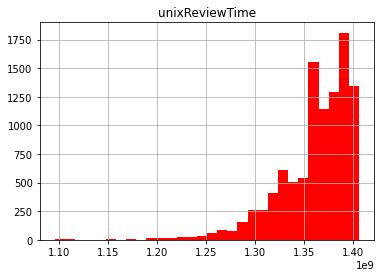

In [22]:
df1.hist('unixReviewTime',bins=30,color='red')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f772f0e1208>]],
      dtype=object)

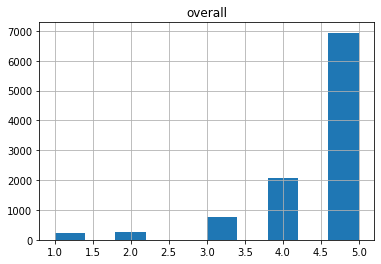

In [23]:
df1.hist('overall')

In [24]:
import datetime
import pandas as pd
df1['year'] = pd.DatetimeIndex(df1['reviewTime']).year

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f772f979ba8>]],
      dtype=object)

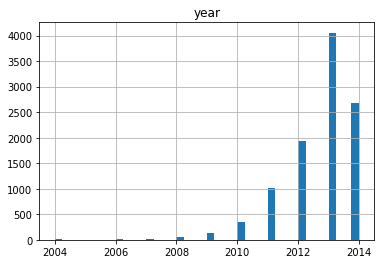

In [25]:
df1.hist("year",bins=40)

# Recommendation Engine


In [26]:
data=df.select(df['asin'],df['reviewerID'],df['overall'])
data.show()

+----------+--------------+-------+
|      asin|    reviewerID|overall|
+----------+--------------+-------+
|1384719342|A2IBPI20UZIR0U|    5.0|
|1384719342|A14VAT5EAX3D9S|    5.0|
|1384719342|A195EZSQDW3E21|    5.0|
|1384719342|A2C00NNG1ZQQG2|    5.0|
|1384719342| A94QU4C90B1AX|    5.0|
|B00004Y2UT|A2A039TZMZHH9Y|    5.0|
|B00004Y2UT|A1UPZM995ZAH90|    5.0|
|B00004Y2UT| AJNFQI3YR6XJ5|    3.0|
|B00004Y2UT|A3M1PLEYNDEYO8|    5.0|
|B00004Y2UT| AMNTZU1YQN1TH|    5.0|
|B00004Y2UT|A2NYK9KWFMJV4Y|    5.0|
|B00005ML71|A35QFQI0M46LWO|    4.0|
|B00005ML71|A2NIT6BKW11XJQ|    3.0|
|B00005ML71|A1C0O09LOLVI39|    5.0|
|B00005ML71|A17SLR18TUMULM|    5.0|
|B00005ML71|A2PD27UKAD3Q00|    2.0|
|B000068NSX| AKSFZ4G1AXYFC|    4.0|
|B000068NSX| A67OJZLHBBUQ9|    5.0|
|B000068NSX|A2EZWZ8MBEDOLN|    5.0|
|B000068NSX|A1CL807EOUPVP1|    5.0|
+----------+--------------+-------+
only showing top 20 rows



In [27]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [28]:
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer


indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(data.columns)-set(['overall'])) ]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(data).transform(data)
transformed.show()

+----------+--------------+-------+----------------+----------+
|      asin|    reviewerID|overall|reviewerID_index|asin_index|
+----------+--------------+-------+----------------+----------+
|1384719342|A2IBPI20UZIR0U|    5.0|            72.0|     781.0|
|1384719342|A14VAT5EAX3D9S|    5.0|           359.0|     781.0|
|1384719342|A195EZSQDW3E21|    5.0|           436.0|     781.0|
|1384719342|A2C00NNG1ZQQG2|    5.0|          1216.0|     781.0|
|1384719342| A94QU4C90B1AX|    5.0|          1137.0|     781.0|
|B00004Y2UT|A2A039TZMZHH9Y|    5.0|            54.0|     629.0|
|B00004Y2UT|A1UPZM995ZAH90|    5.0|           348.0|     629.0|
|B00004Y2UT| AJNFQI3YR6XJ5|    3.0|           324.0|     629.0|
|B00004Y2UT|A3M1PLEYNDEYO8|    5.0|            12.0|     629.0|
|B00004Y2UT| AMNTZU1YQN1TH|    5.0|           185.0|     629.0|
|B00004Y2UT|A2NYK9KWFMJV4Y|    5.0|             4.0|     629.0|
|B00005ML71|A35QFQI0M46LWO|    4.0|           425.0|     870.0|
|B00005ML71|A2NIT6BKW11XJQ|    3.0|     

In [29]:
(training,testing)=transformed.randomSplit([0.7, 0.3])

In [30]:
alsmodel=ALS(regParam=0.09,rank=25,maxIter=5,userCol="reviewerID_index",itemCol="asin_index",ratingCol="overall",coldStartStrategy="drop",nonnegative=True)
model=alsmodel.fit(training)

In [31]:
reg_evaluator=RegressionEvaluator(metricName="rmse",labelCol="overall",predictionCol="prediction")
prediction=model.transform(testing)
rmse_value=reg_evaluator.evaluate(prediction)
print("Root Mean Square error Value="+str(rmse_value))
prediction.show()

Root Mean Square error Value=1.2748521366443937
+----------+--------------+-------+----------------+----------+----------+
|      asin|    reviewerID|overall|reviewerID_index|asin_index|prediction|
+----------+--------------+-------+----------------+----------+----------+
|B000CCJP4I| A4BTCECGQAIUI|    4.0|            34.0|     148.0| 3.3795679|
|B000CCJP4I| AJ3MI4QT7339J|    5.0|           847.0|     148.0| 2.8913832|
|B000CCJP4I|A3J8U952XAL34Z|    5.0|           502.0|     148.0| 4.4617605|
|B000CCJP4I|A12P4A1OC41KUO|    3.0|           344.0|     148.0| 3.7280803|
|B000CCJP4I| ADH0O8UVJOT10|    5.0|             0.0|     148.0|  4.920857|
|B000KIPTE4|A3F49ZMUC1GSRP|    4.0|          1165.0|     463.0| 4.5564685|
|B000KIPTE4|A2EZWZ8MBEDOLN|    5.0|             3.0|     463.0| 4.4081445|
|B000KIPTE4|A37E0KYNJQNP1E|    5.0|           408.0|     463.0| 4.5930133|
|B001OLZYUU| AKT2VSLZHDD81|    5.0|           205.0|     471.0|  4.662411|
|B001OLZYUU| A3FQ9WYUHG9CD|    4.0|           264.0|

In [32]:
users_recommendations=model.recommendForAllUsers(20).show()

+----------------+--------------------+
|reviewerID_index|     recommendations|
+----------------+--------------------+
|             471|[[465, 5.924256],...|
|            1342|[[771, 7.0282116]...|
|             463|[[738, 5.712733],...|
|             833|[[738, 6.529595],...|
|             496|[[427, 5.697929],...|
|             148|[[771, 5.876934],...|
|            1088|[[392, 4.0636272]...|
|            1238|[[771, 6.0294123]...|
|             540|[[624, 5.103867],...|
|             392|[[793, 5.182935],...|
|             243|[[465, 5.488746],...|
|             623|[[427, 5.5891], [...|
|            1084|[[859, 5.6243157]...|
|            1025|[[771, 5.772807],...|
|            1395|[[793, 4.903931],...|
|             737|[[738, 5.326231],...|
|             897|[[771, 5.4010506]...|
|            1127|[[852, 6.133562],...|
|             858|[[653, 5.017395],...|
|            1270|[[771, 5.021954],...|
+----------------+--------------------+
only showing top 20 rows



In [33]:
import pandas as pd
recommend=model.recommendForAllUsers(10).toPandas()
recommends=recommend.recommendations.apply(pd.Series) \
            .merge(recommend, right_index = True, left_index = True) \
            .drop(["recommendations"], axis = 1) \
            .melt(id_vars = ['reviewerID_index'], value_name = "recommendation") \
            .drop("variable", axis = 1) \
            .dropna() 
recommends=recommends.sort_values('reviewerID_index')
recommends=pd.concat([recommends['recommendation'].apply(pd.Series), recommends['reviewerID_index']], axis = 1)
recommends.columns = [
        'ProductID_index',
        'Rating',
        'UserID_index'
     ]
dataf=transformed.select(transformed['reviewerID'],transformed['reviewerID_index'],transformed['asin'],transformed['asin_index'])
dataf=dataf.toPandas()
data1 =dict(zip(dataf['reviewerID_index'],dataf['reviewerID']))
data2=dict(zip(dataf['asin_index'],dataf['asin']))
recommends['reviewerID']=recommends['UserID_index'].map(data1)
recommends['asin']=recommends['ProductID_index'].map(data2)
recommends=recommends.sort_values('reviewerID')
recommends.reset_index(drop=True, inplace=True)
newdata=recommends[['reviewerID','asin','Rating']]
newdata['recommendations'] = list(zip(newdata.asin, newdata.Rating))
data3=newdata[['reviewerID','recommendations']]  
data_new=data3['recommendations'].groupby([data3.reviewerID]).apply(list).reset_index()
print(data_new)

/home/thunderwolf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                 reviewerID                                    recommendations
0     A00625243BI8W1SSZNLMD  [(B0010CHS8E, 5.858282566070557), (B004J27QXY,...
1            A10044ECXDUVKS  [(B0002E5518, 4.9952778816223145), (B0002M6CVC...
2            A102MU6ZC9H1N6  [(B0002CZVHI, 5.575512886047363), (B0010CHS8E,...
3            A109JTUZXO61UY  [(B00F2PKRJW, 5.867031574249268), (B0002CZVHI,...
4            A109ME7C09HM2M  [(B000KGYAYQ, 5.502983570098877), (B001L8IJ0I,...
...                     ...                                                ...
1420          AZJPNK73JF3XP  [(B000EPVXWU, 5.3978118896484375), (B001D2TPZU...
1421          AZMHABTPXVLG3  [(B002QKRUJG, 3.8490774631500244), (B0002E1OVS...
1422          AZMIKIG4BB6BZ  [(B00186L9X2, 5.234279155731201), (B0007OGTGS,...
1423          AZPDO6FLSMLFP  [(B005EHILV4, 4.830984115600586), (B0010CHS8E,...
1424          AZVME8JMPD3F4  [(B005M0CK9M, 4.67808723449707), (B0038MTH8S, ...

[1425 rows x 2 columns]


In [34]:
import nltk

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import os
from time import time
import sys

In [36]:
dataframe=spark.read.json("Musical_Instruments_5.json")
dataframe2=dataframe.toPandas()
dataframe2

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",5.0,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",5.0,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
2,1384719342,"[1, 1]",5.0,The primary job of this device is to block the...,"08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
3,1384719342,"[0, 0]",5.0,Nice windscreen protects my MXL mic and preven...,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
4,1384719342,"[0, 0]",5.0,This pop filter is great. It looks and perform...,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800
...,...,...,...,...,...,...,...,...,...
10256,B00JBIVXGC,"[0, 0]",5.0,"Great, just as expected. Thank to all.","07 20, 2014",A14B2YH83ZXMPP,Lonnie M. Adams,Five Stars,1405814400
10257,B00JBIVXGC,"[0, 0]",5.0,I've been thinking about trying the Nanoweb st...,"07 2, 2014",A1RPTVW5VEOSI,Michael J. Edelman,"Long life, and for some players, a good econom...",1404259200
10258,B00JBIVXGC,"[0, 0]",4.0,I have tried coated strings in the past ( incl...,"07 22, 2014",AWCJ12KBO5VII,Michael L. Knapp,Good for coated.,1405987200
10259,B00JBIVXGC,"[0, 0]",4.0,"Well, MADE by Elixir and DEVELOPED with Taylor...","07 1, 2014",A2Z7S8B5U4PAKJ,"Rick Langdon ""Scriptor""",Taylor Made,1404172800


In [37]:
dataframe = dataframe2.iloc[:, [1,2,3]]

#split numerator and denominator
dataframe['helpful_numerator'] = dataframe['helpful'].apply(lambda x: x[0])
dataframe['helpful_denominator'] = dataframe['helpful'].apply(lambda x: x[1])

# delete un-needed 'helpful catagory
del dataframe['helpful']

#Check if we have any null values
print (dataframe.isnull().sum())

overall                0
reviewText             0
helpful_numerator      0
helpful_denominator    0
dtype: int64


/home/thunderwolf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/thunderwolf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [38]:
dataframe.describe()

,overall,helpful_numerator,helpful_denominator
count,10261.000000,10261.00000,10261.000000
mean,4.488744,1.57090,1.858103
std,0.894642,8.92045,9.480797
min,1.000000,0.00000,0.000000
25%,4.000000,0.00000,0.000000
50%,5.000000,0.00000,0.000000
75%,5.000000,1.00000,1.000000
max,5.000000,290.00000,300.000000


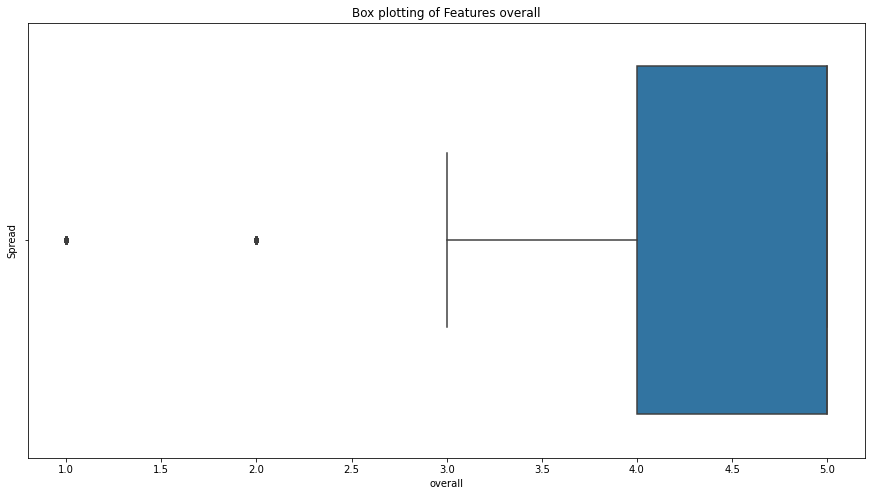

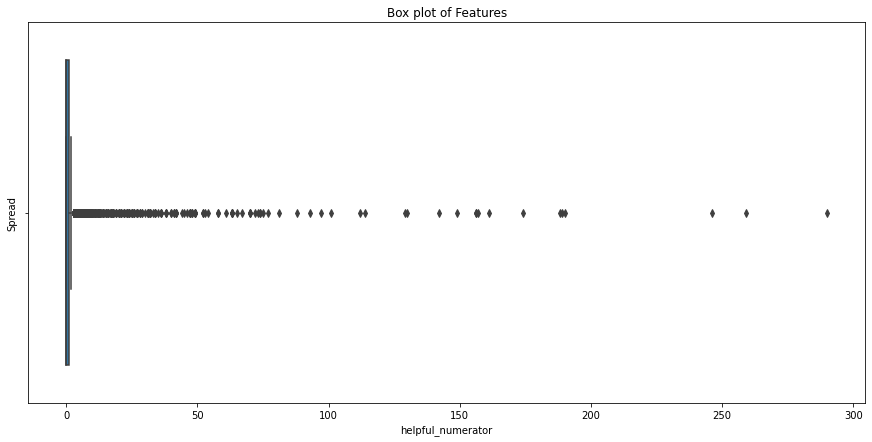

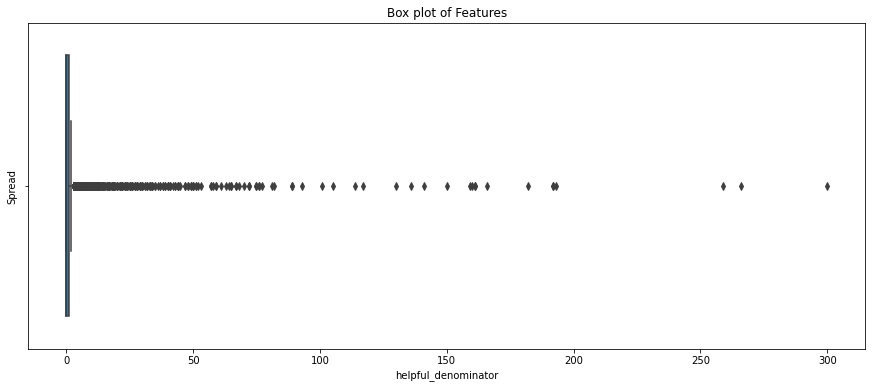

In [39]:
plt.figure(figsize=(15,8))
plt.title('Box plotting of Features overall')
plt.ylabel('Spread')
plt.xlabel('Features')
ld=dataframe.columns
display(sns.boxplot(dataframe['overall']))
plt.figure(figsize=(15,7))
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xlabel('Features')
ld1=dataframe.columns
display(sns.boxplot(dataframe['helpful_numerator']))
plt.figure(figsize=(15,6))
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xlabel('Features')
ld2=dataframe.columns
display(sns.boxplot(dataframe['helpful_denominator']))

In [40]:
print (dataframe['helpful_numerator'].idxmax(axis=0, skipna=True))
print (dataframe['helpful_denominator'].idxmax(axis=0, skipna=True))
dataframe.iloc[[8913,8914]]

8914
8914


,overall,reviewText,helpful_numerator,helpful_denominator
8913,5.0,Before I bought this I had to use a tuner on m...,0,0
8914,5.0,"I own several tuners, and two Snark-2 tuners, ...",290,300


In [41]:
dataframeX = dataframe[(dataframe.helpful_denominator > 5)].copy()
dataframeX.shape

(627, 4)

In [42]:
import numpy as np
threshold = 0.5
dataframeX.loc[:, 'Helpful'] = np.where(dataframeX.loc[:, 'helpful_numerator'] \
                                 / dataframeX.loc[:, 'helpful_denominator'] > threshold, 1, 0)
dataframeX.head(3)

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
1,5.0,The product does exactly as it should and is q...,13,14,1
10,5.0,"Monster makes a wide array of cables, includin...",6,6,1
46,4.0,Cheap and good texture rubber that does not ge...,12,13,1


In [43]:
#Check the balance
print ('Count:')
display(dataframeX.groupby('Helpful').count())

Count:


,overall,reviewText,helpful_numerator,helpful_denominator
Helpful,,,,
0,62,62,62,62
1,565,565,565,565


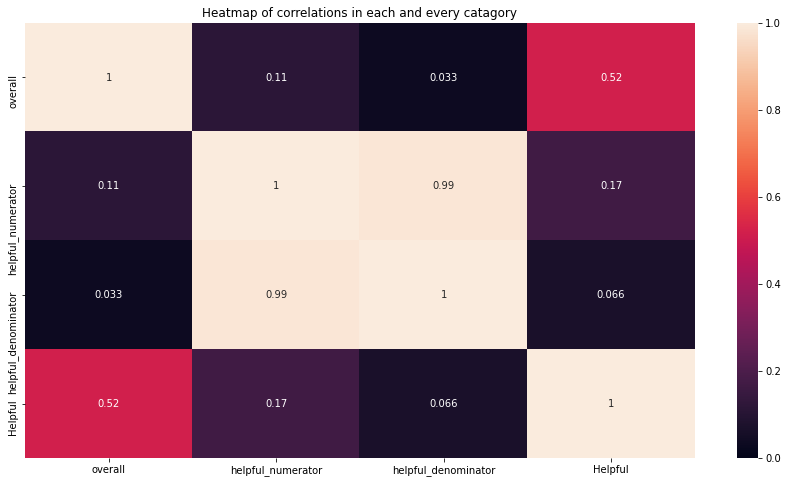

In [44]:
#Visualize correlation of the data
correlations = dataframeX.corr()
plt.figure(figsize = (15,8))
plt.title("Heatmap of correlations in each and every catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

In [45]:
# convert text to lowercase
dataframeX.loc[:, 'reviewText'] = dataframeX['reviewText'].str.lower()
dataframeX['reviewText'].head()

1      the product does exactly as it should and is q...
10     monster makes a wide array of cables, includin...
46     cheap and good texture rubber that does not ge...
77     for the price, fantastic.they do feel light an...
103    this adapter cable for stereo mics to work wit...
Name: reviewText, dtype: object

In [46]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")
#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems
#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists('features.pickle'):
    print ('Pickled file already present, loading...')
    features = pickle.load( open( "features.pickle", "rb" ) )
    print ('Pickle file loaded.')
else:
    #define the vectorizer
    vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
    #fit the vectorizers to the data.
    features = vectorizer.fit_transform(dataframeX['reviewText'])
features

/home/thunderwolf/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<627x1542 sparse matrix of type '<class 'numpy.float64'>'
	with 39054 stored elements in Compressed Sparse Row format>

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,dataframeX['Helpful'], test_size=0.3, random_state=0)

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

In [49]:
from sklearn.linear_model import LogisticRegression
clf_list1 = [LogisticRegression(random_state = 0)]
x_tr = X_train.toarray()
x_te = X_test.toarray()


# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers 
for clf1 in clf_list1:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf1, a, b, x_te, y_test)

Training a LogisticRegression using a training set size of 438. . .
Trained model in 0.1703 seconds
Made predictions in 0.0013 seconds.
ROC_AUC score for training set: 0.9999.
Made predictions in 0.0007 seconds.
ROC_AUC score for test set: 0.7702.

Training a LogisticRegression using a training set size of 438. . .
Trained model in 0.0533 seconds
Made predictions in 0.0026 seconds.
ROC_AUC score for training set: 0.9999.
Made predictions in 0.0007 seconds.
ROC_AUC score for test set: 0.7702.

Training a LogisticRegression using a training set size of 438. . .
Trained model in 0.0259 seconds
Made predictions in 0.0012 seconds.
ROC_AUC score for training set: 0.9999.
Made predictions in 0.0007 seconds.
ROC_AUC score for test set: 0.7702.



In [50]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = LogisticRegression(random_state=seed)
    clf3.fit(X_train, y_train)
    probas =clf3.predict_proba(X_test)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.7702


In [51]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = LogisticRegression(random_state=seed)
    clf3.fit(X_train, y_train)
    probas =clf3.predict_proba(X_test)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.7702
